In [4]:
import tensorflow as tf
from glob import glob
import pspnet
import matplotlib.pyplot as plt
import numpy as np

#import Augmentor
print('Tensorflow', tf.__version__)

Tensorflow 2.3.0


In [ ]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=e98dfb9599d5425fddb8a589034aef4640e428bc85d3b560222d93af1fc946e8
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [2]:
!unzip mentah.zip

Streaming output truncated to the last 5000 lines.
  inflating: mentah/trainasli/glass273.jpg  
  inflating: __MACOSX/mentah/trainasli/._glass273.jpg  
  inflating: mentah/trainasli/trash70.jpg  
  inflating: __MACOSX/mentah/trainasli/._trash70.jpg  
  inflating: mentah/trainasli/trash64.jpg  
  inflating: __MACOSX/mentah/trainasli/._trash64.jpg  
  inflating: mentah/trainasli/plastic318.jpg  
  inflating: __MACOSX/mentah/trainasli/._plastic318.jpg  
  inflating: mentah/trainasli/metal223.jpg  
  inflating: __MACOSX/mentah/trainasli/._metal223.jpg  
  inflating: mentah/trainasli/plastic324.jpg  
  inflating: __MACOSX/mentah/trainasli/._plastic324.jpg  
  inflating: mentah/trainasli/plastic330.jpg  
  inflating: __MACOSX/mentah/trainasli/._plastic330.jpg  
  inflating: mentah/trainasli/metal237.jpg  
  inflating: __MACOSX/mentah/trainasli/._metal237.jpg  
  inflating: mentah/trainasli/cardboard279.jpg  
  inflating: __MACOSX/mentah/trainasli/._cardboard279.jpg  
  inflating: mentah/trai

In [5]:
image_list = sorted(glob('mentah/train/*'))
mask_list = sorted(glob('mentah/trainannot/*'))
print('Found {} images \nFound {} masks'.format(len(image_list), len(mask_list)))

Found 1759 images 
Found 1759 masks


In [6]:
def imshow(img, mask):
    img = tf.io.read_file(img)
    img = tf.image.decode_image(img, channels=3)
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(1,2,1)
    ax.set_title('Image')
    ax.axis('off')
    ax.imshow(img)
    
    mask = tf.io.read_file(mask)
    mask = tf.image.decode_image(mask, channels=1)
    ax = fig.add_subplot(1,2,2)
    ax.set_title('Mask')
    ax.axis('off')
    ax.imshow(np.squeeze(mask))

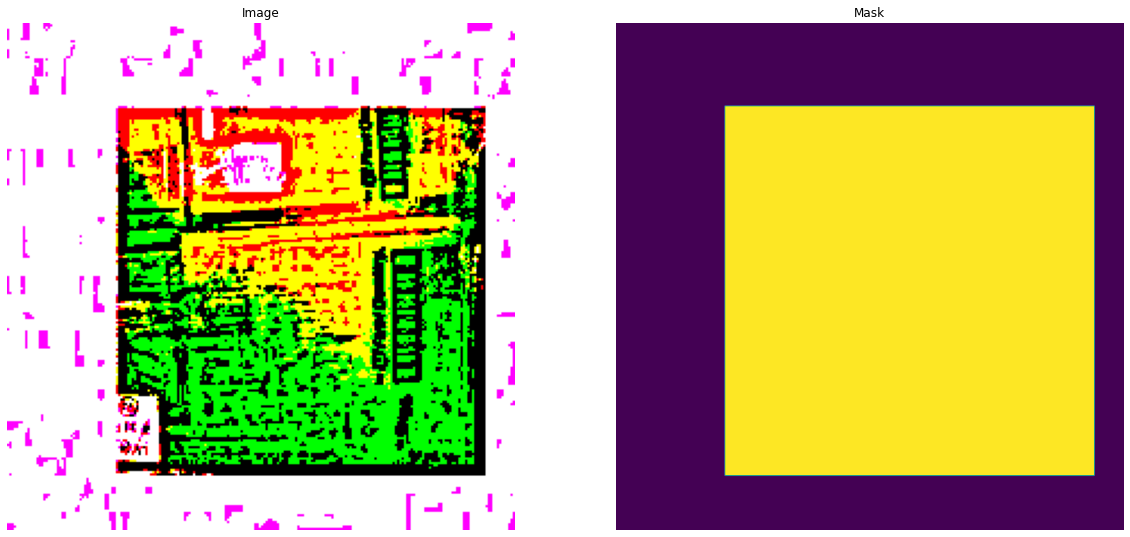

In [7]:
imshow(image_list[10], mask_list[10])

In [8]:
H, W = 224, 224
batch_size = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
aug = sorted(glob('mentah/trainasli/*'))

In [10]:
def get_image(path, mask=False):
    img = tf.io.read_file(path)
    if not mask:
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size=[H, W])
        img /= 255.
    else:
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, size=[H, W]) > 0
        img = tf.cast(img, tf.float32)
    return img

def load_data(image_path, mask_path):
    return get_image(image_path), get_image(mask_path, mask=True)

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((aug, mask_list))
train_ds = train_ds.shuffle(256)
train_ds = train_ds.map(load_data, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(AUTOTUNE)

In [12]:
print(train_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>


In [13]:
def dice_loss(pred, actual):
    num = 2 * tf.reduce_sum((pred * actual), axis=-1)
    den = tf.reduce_sum((pred + actual), axis=-1)
    return 1 - (num + 1) / (den + 1)

In [14]:
model = pspnet.pspnet50(1, (224, 224, 3), 0.0001)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
test_list = sorted(glob('mentah/valasli/*'))
mask_test = sorted(glob('mentah/valannot/*'))
print('Found {} images \nFound {} masks'.format(len(test_list), len(mask_test)))

Found 384 images 
Found 384 masks


In [16]:
test_ds = tf.data.Dataset.from_tensor_slices((test_list, mask_test))
test_ds = test_ds.shuffle(256)
test_ds = test_ds.map(load_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.repeat()
test_ds = test_ds.prefetch(AUTOTUNE)

print(test_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>


In [17]:
history = model.fit(train_ds, epochs=35, steps_per_epoch=len(image_list)//batch_size, validation_data=test_ds, validation_steps=len(test_list)//batch_size)

Epoch 1/35
175/175 [==============================] - 209s 1s/step - loss: 0.2148 - dice_coef: 0.5707 - val_loss: 0.2493 - val_dice_coef: 0.3112
Epoch 2/35
175/175 [==============================] - 207s 1s/step - loss: 0.1250 - dice_coef: 0.7544 - val_loss: 0.1587 - val_dice_coef: 0.5655
Epoch 3/35
175/175 [==============================] - 208s 1s/step - loss: 0.0674 - dice_coef: 0.8644 - val_loss: 0.0686 - val_dice_coef: 0.8554
Epoch 4/35
175/175 [==============================] - 208s 1s/step - loss: 0.0470 - dice_coef: 0.8998 - val_loss: 0.0452 - val_dice_coef: 0.9087
Epoch 5/35
175/175 [==============================] - 208s 1s/step - loss: 0.0373 - dice_coef: 0.9174 - val_loss: 0.0353 - val_dice_coef: 0.9265
Epoch 6/35
175/175 [==============================] - 208s 1s/step - loss: 0.0302 - dice_coef: 0.9318 - val_loss: 0.0302 - val_dice_coef: 0.9367
Epoch 7/35
175/175 [==============================] - 208s 1s/step - loss: 0.0276 - dice_coef: 0.9359 - val_loss: 0.0280 - val_dic

In [18]:
model.save_weights('weightsglobal.h5')

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


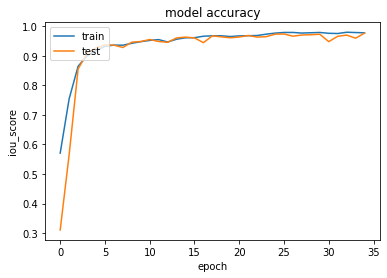

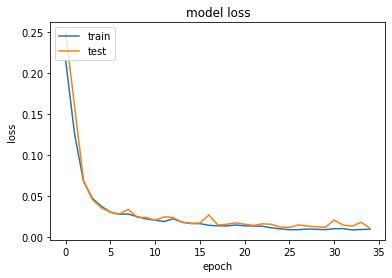

In [18]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model accuracy')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# model = tf.keras.models.load_model('unet_1.h5')
# model.load_weights('weights.h5')

H, W = 224, 224

def get_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[H, W])
    img /= 255.
    return img[None, ...]

In [20]:
images = glob('mentah/test/*')
imagesorted = sorted(glob('mentah/testasli/*'))
annot = sorted(glob('mentah/testannot/*'))

In [21]:
def plot_predictions(image):
    fig = plt.figure(figsize=(8, 4))
    sort = get_image(imagesorted[image])
    y = model.predict(sort)
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('img')
    ax.imshow(sort[0, ...])
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('mask')
    ax.imshow(np.squeeze(y))
    y.savefig(f'results/{image}.png')
  
print(image_list[214])

mentah/train/cardboard39.png


AttributeError: ignored

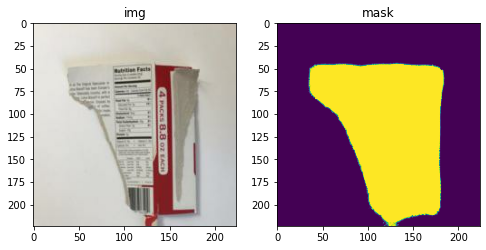

In [22]:
plot_predictions(271)

In [ ]:
model.save('pspnet_28.h5')

In [ ]:
import Augmentor

p = Augmentor.Pipeline("./preprocessed2/train/")
# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
p.ground_truth("./preprocessed2/trainannot")
# Add operations to the pipeline as normal:
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)
p.sample(50)

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F101EE42BE0>:   8%|▊         | 4/50 [00:00<00:06,  7.29 Samples/s]

Initialised with 2143 image(s) found.
Output directory set to ./preprocessed2/train/output.0 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F101EE74A90>: 100%|██████████| 50/50 [00:00<00:00, 68.61 Samples/s]
